In [202]:
import json
import requests
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show as Show
from rasterio import mask as mask
import pylab as plt
from rasterstats import point_query
import warnings
warnings.filterwarnings('ignore')

### Landslide analysis of POIs for EU countries
* import POI databases created earlier
* query school & hospital locations based on Global Landslide Hazard Map
* merge with ADM1 boundaries
* plot the results

In [196]:
landslide_pth = data+'/energy/LS_RF_Mean_1980-2018.tif'  # ARUP landslide layer downloaded from DDH (rainfall trigge)

#### 1. Get landslide data and subnational boundaries

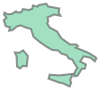

In [197]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # natural earth dataset used for country outlines
country = 'Italy'
geom = world.geometry[world.name == country].reset_index(drop=True)[0]
geom

In [198]:
with rasterio.open(landslide_pth) as src:
    maskData, maskTransform = mask.mask(src, [geom], crop=True, nodata=src.nodatavals[0])

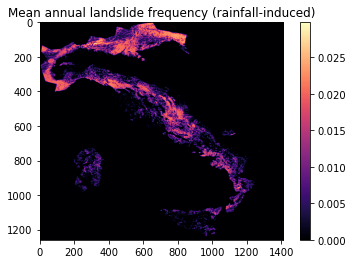

In [203]:
plt.imshow(maskData[0,:,:], cmap = 'magma')
plt.colorbar()
plt.title('Mean annual landslide frequency (rainfall-induced)');

In [200]:
def get_boundaries(alpha3,verbose=True):
    r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM=ADM1".format(alpha3))
    dlPath = r.json()[0]['gjDownloadURL']
    geoBoundary = requests.get(dlPath).json()
    gdf = gpd.GeoDataFrame.from_features(geoBoundary['features'])[['geometry','shapeName']]
    if verbose:
        print('{}: retrieved {} features'.format(alpha3, len(gdf)))
    return(gdf)

In [201]:
boundaries_Austria = get_boundaries('AUT')
boundaries_Croatia = get_boundaries('HRV')
boundaries_Slovakia = get_boundaries('SVK')
boundaries_Italy = get_boundaries('ITA')
boundaries_Slovenia = get_boundaries('SVN')

AUT: retrieved 9 features
HRV: retrieved 21 features
SVK: retrieved 8 features
ITA: retrieved 20 features
SVN: retrieved 12 features


#### 2. Import POIs dataframe and query landslide map
POIs for schools and hospitals created earlier.

In [ ]:
# to import POIs directly from OSM:
#gdf = ox.pois.pois_from_place('Italy',{'amenity':'school'})
#gdf=gdf[['name','geometry']]
#gdf.geometry = [geom.centroid if geom.type in ['Polygon','MultiPolygon','LineString'] else geom for geom in gdf.geometry]

In [204]:
# load POIs from disk and run point query against Global Landslide Hazard Map

def pois_with_landslide_risk(country,poi):
    gdf = gpd.read_file('data/{}_{}.shp'.format(country,poi))
    gdf['landslide_prob'] = point_query(gdf, landslide_pth)
    gdf.landslide_prob = gdf.landslide_prob.fillna(0)
    return(gdf)

In [205]:
croatia_schools = get_pois_with_landslide_risk('croatia','school')
slovakia_schools = get_pois_with_landslide_risk('slovakia','school')
slovenia_schools = get_pois_with_landslide_risk('slovenia','school')
austria_schools = get_pois_with_landslide_risk('austria','school')
italy_schools = get_pois_with_landslide_risk('italy','school')

In [206]:
croatia_hospitals = get_pois_with_landslide_risk('croatia','hospital')
slovakia_hospitals = get_pois_with_landslide_risk('slovakia','hospital')
slovenia_hospitals = get_pois_with_landslide_risk('slovenia','hospital')
austria_hospitals = get_pois_with_landslide_risk('austria','hospital')
italy_hospitals = get_pois_with_landslide_risk('italy','hospital')

#### 3. Visualize landslide-affected assets

In [207]:
italy_hospitals['non-zero_risk'] = [bool(int(value)) for value in italy_hospitals.landslide_prob > 0]
italy_hospitals['risk_1_percent_plus'] = [bool(int(value)) for value in italy_hospitals.landslide_prob > 1]
italy_hospitals['risk_2_percent_plus'] = [bool(int(value)) for value in italy_hospitals.landslide_prob > 2]

In [208]:
for col, percent in zip(['non-zero_risk','risk_1_percent_plus','risk_2_percent_plus'],['0','1','2']):
    print("{:.1f}% of hospitals have mean annual landslide probability exceeding {}%".format(italy_schools[col].mean() * 100, percent))

KeyError: 'non-zero_risk'

In [ ]:
f,ax = plt.subplots(figsize=[12,10])
boundaries_Italy.plot(edgecolor='k',facecolor='blue',alpha=0.2,ax=ax)
italy_hospitals[italy_hospitals['risk_2_percent_plus']].plot(ax=ax,color='r',markersize=6)
italy_hospitals[~italy_hospitals['risk_2_percent_plus']].plot(ax=ax,color='b',markersize=1)
plt.title('Italy: landslide affected hospitals');

#### 4. Subnational distribution of landslide risk at schools & hospitals

In [ ]:
# get mean landslide frequency by admin unit

def mean_poi_risk_by_ADM(boundaries, poi_gdf,poi_type='school',add_n_pois = True):
    poi_gdf = gpd.sjoin(poi_gdf,boundaries)
    poi_gdf.drop(columns=['index_right'],inplace=True)
    mean_landslide_prob = poi_gdf.groupby('shapeName').mean().sort_values(by='landslide_prob',ascending=False)
    boundaries = boundaries.merge(mean_landslide_prob,left_on='shapeName',right_on = mean_landslide_prob.index)
    boundaries.rename(columns={'landslide_prob':'mean_LS_frequency_{}'.format(poi_type)},inplace=True)
    
    if add_n_pois:
        counts = poi_gdf.shapeName.value_counts()
        counts.name = 'n_pois'
        boundaries = boundaries.merge(counts,left_on='shapeName',right_on=counts.index)
    return(boundaries)

In [ ]:
boundaries_Austria = mean_poi_risk_by_ADM(boundaries_Austria,austria_schools)
boundaries_Croatia = mean_poi_risk_by_ADM(boundaries_Croatia,croatia_schools)
boundaries_Slovakia = mean_poi_risk_by_ADM(boundaries_Slovakia,slovakia_schools)
boundaries_Slovenia = mean_poi_risk_by_ADM(boundaries_Slovenia,slovenia_schools)
boundaries_Italy = mean_poi_risk_by_ADM(boundaries_Italy,italy_schools)

In [ ]:
boundaries_Italy[['shapeName','mean_LS_frequency_school','n_pois']].sort_values(
    'mean_LS_frequency_school',ascending=False).reset_index(drop=True).head()

In [ ]:
dfs_list = [austria_schools,italy_schools,croatia_schools,slovakia_schools,slovenia_schools]
gdfs_list = [boundaries_Austria,boundaries_Italy,boundaries_Croatia,boundaries_Slovakia,boundaries_Slovenia]
names = ['Austria','Italy','Croatia','Slovakia','Slovenia']
school_numbers = [len(df) for df in dfs_list]

for gdf,country_name,n in zip(gdfs_list, names, school_numbers):
    gdf.plot(column='mean_LS_frequency_school',vmax=1.5,cmap='viridis',legend=True)
    plt.tight_layout()
    plt.title('{}: mean LS frequency per region (n schools = {})'.format(country_name, n));

#### 3. Mean landslide frequency for schools & hospitals (at country level)

In [ ]:
dfs_list = [croatia_schools,slovakia_schools,slovenia_schools,austria_schools,italy_schools]
names = ['croatia','slovakia','slovenia','austria','italy']

country_mean_schools = pd.DataFrame({'country': names, 'mean_annual_landslide_frequency': [df.landslide_prob.mean() for df in dfs_list]})
country_mean_schools.sort_values(by='mean_annual_landslide_frequency',inplace=True)
country_mean_schools.reset_index(drop=True,inplace=True)
country_mean_schools

In [ ]:
dfs_list = [croatia_hospitals,slovakia_hospitals,slovenia_hospitals,austria_hospitals,italy_hospitals]
names = ['croatia','slovakia','slovenia','austria','italy']

country_mean_hospitals = pd.DataFrame({'country': names, 'mean_annual_landslide_frequency': [df.landslide_prob.mean() for df in dfs_list]})
country_mean_hospitals.sort_values(by='country',inplace=True)
country_mean_hospitals.reset_index(drop=True,inplace=True)
country_mean_hospitals

In [ ]:
f,ax = plt.subplots()
width=0.4
height = 0.4
ind=np.arange(len(country_mean_schools))
ax.barh(y= ind, width=country_mean_schools.mean_annual_landslide_frequency,height=height,label='schools')
ax.barh(y= ind + width, width=country_mean_hospitals.mean_annual_landslide_frequency,height=height,label='hospitals')

ax.set(yticks=ind + width, yticklabels=country_mean_schools.country)
ax.legend()

plt.title('Mean annual landslide frequency per country (rainfall-induced)')
plt.show()